In [16]:
import numpy as np 
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from collections import OrderedDict

In [35]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                             ])
# Download and load the training data
trainset = datasets.MNIST('data/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('data/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [36]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('logits', nn.Linear(hidden_sizes[1], output_size))]))

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [40]:
epochs = 3
print_every = 40
steps = 0
for e in range(epochs):
    running_loss = 0
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            
            running_loss = 0

Epoch: 1/3...  Loss: 2.2867
Epoch: 1/3...  Loss: 2.2697
Epoch: 1/3...  Loss: 2.2481
Epoch: 1/3...  Loss: 2.2276
Epoch: 1/3...  Loss: 2.2081
Epoch: 1/3...  Loss: 2.1821
Epoch: 1/3...  Loss: 2.1545
Epoch: 1/3...  Loss: 2.1294
Epoch: 1/3...  Loss: 2.0921
Epoch: 1/3...  Loss: 2.0590
Epoch: 1/3...  Loss: 2.0249
Epoch: 1/3...  Loss: 1.9781
Epoch: 1/3...  Loss: 1.9230
Epoch: 1/3...  Loss: 1.8799
Epoch: 1/3...  Loss: 1.8125
Epoch: 1/3...  Loss: 1.7528
Epoch: 1/3...  Loss: 1.6956
Epoch: 1/3...  Loss: 1.6270
Epoch: 1/3...  Loss: 1.5477
Epoch: 1/3...  Loss: 1.4974
Epoch: 1/3...  Loss: 1.3966
Epoch: 1/3...  Loss: 1.3474
Epoch: 1/3...  Loss: 1.2821
Epoch: 2/3...  Loss: 0.6762
Epoch: 2/3...  Loss: 1.1801
Epoch: 2/3...  Loss: 1.1149
Epoch: 2/3...  Loss: 1.0791
Epoch: 2/3...  Loss: 1.0362
Epoch: 2/3...  Loss: 0.9853
Epoch: 2/3...  Loss: 0.9820
Epoch: 2/3...  Loss: 0.9454
Epoch: 2/3...  Loss: 0.9040
Epoch: 2/3...  Loss: 0.8613
Epoch: 2/3...  Loss: 0.8155
Epoch: 2/3...  Loss: 0.8206
Epoch: 2/3...  Loss:

In [15]:
import numpy as np 
import matplotlib.pyplot as plt 

def plot_learning_curve(x, scores, epsilons, filename):
    fig = plt.figure()
    ax = fig.add_subplot(111, label='1')
    ax2 = fig.add_subplot(111, label='2', frame_on=False)

    color='C0'
    ax.plot(x, epsilons, color=color)
    ax.set_xlabel('Training Steps', color=color)
    ax.set_ylabel('Epsilon', color=color)
    ax.tick_params(axis='x', color=color)
    ax.tick_params(axis='y', color=color)

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-100):(t+1)])

    color = 'C1'
    ax2.scatter(x, running_avg, color=color)
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color=color)
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', color=color)

    plt.savefig(filename)

In [2]:
import gym
import numpy as np
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 
import torch as T

In [6]:
class LinearDeepQ(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(LinearDeepQ, self).__init__()

        self.fc1 = nn.Linear(*input_dims, 128)
        self.fc2 = nn.Linear(128, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        actions = F.relu(self.fc1(state))
        actions = self.fc2(actions)
        return actions

In [7]:
class Agent():
    def __init__(self, input_dims, n_actions, lr, gamma=0.99, epsilon=1.0, eps_decay=1e-5, eps_min=0.01):
        self.lr = lr
        self.input_dims = input_dims 
        self.n_actions = n_actions 
        self.gamma = gamma 
        self.epsilon = epsilon 
        self.eps_decay = eps_decay 
        self.eps_min = eps_min 
        self.action_space = [i for i in range(self.n_actions)]

        self.Q = LinearDeepQ(self.lr, self.n_actions, self.input_dims)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor(observation, dtype=T.float).to(self.Q.device)
            actions = self.Q.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action 

    def decrement_epsilon(self):
        self.epsilon = self.epsilon = self.eps_decay if self.epsilon > self.eps_min else self.eps_min

    def learn(self, state, action, reward, next_state):
        self.Q.zero_grad()
        state = T.tensor(state, dtype=T.float).to(self.Q.device)
        action = T.tensor(action).to(self.Q.device)
        reward = T.tensor(reward).to(self.Q.device)
        next_state = T.tensor(next_state, dtype=T.float).to(self.Q.device)

        q_pred = self.Q.forward(state)[action]
        q_next = self.Q.forward(next_state).max()
        q_target = reward + self.gamma*q_next

        loss = self.Q.loss(q_target, q_pred).to(self.Q.device)
        loss.backward()
        self.Q.optimizer.step()
        self.decrement_epsilon()

In [11]:
env = gym.make('CartPole-v1')
n_games = 10000
scores = []
eps_history = []

agent = Agent(lr=0.0001, input_dims=env.observation_space.shape, n_actions=env.action_space.n)

for i in range(n_games):
    score = 0
    done = False 
    obs = env.reset()

    while not done:
        action = agent.choose_action(obs)
        next_obs, reward, done, info = env.step(action)
        score += reward 
        agent.learn(obs, action, reward, next_obs)
        obs = next_obs

    scores.append(score)
    eps_history.append(agent.epsilon)

    if i % 100 == 0:
        avg_score = np.mean(scores[-100:])
        print('episode ', i, 'score %.1f avg score %.1f epsilon %.2f' %
                (score, avg_score, agent.epsilon))


episode  0 score 77.0 avg score 77.0 epsilon 0.01
episode  100 score 11.0 avg score 13.2 epsilon 0.01
episode  200 score 25.0 avg score 18.7 epsilon 0.01
episode  300 score 34.0 avg score 47.8 epsilon 0.01
episode  400 score 22.0 avg score 23.8 epsilon 0.01
episode  500 score 20.0 avg score 22.4 epsilon 0.01
episode  600 score 27.0 avg score 22.7 epsilon 0.01
episode  700 score 28.0 avg score 27.0 epsilon 0.01
episode  800 score 84.0 avg score 66.9 epsilon 0.01
episode  900 score 21.0 avg score 43.8 epsilon 0.01
episode  1000 score 24.0 avg score 26.5 epsilon 0.01
episode  1100 score 27.0 avg score 27.0 epsilon 0.01
episode  1200 score 34.0 avg score 26.2 epsilon 0.01
episode  1300 score 24.0 avg score 27.6 epsilon 0.01
episode  1400 score 23.0 avg score 25.6 epsilon 0.01
episode  1500 score 30.0 avg score 25.6 epsilon 0.01
episode  1600 score 39.0 avg score 26.2 epsilon 0.01
episode  1700 score 22.0 avg score 28.4 epsilon 0.01
episode  1800 score 34.0 avg score 27.0 epsilon 0.01
episo

NameError: name 'rnage' is not defined

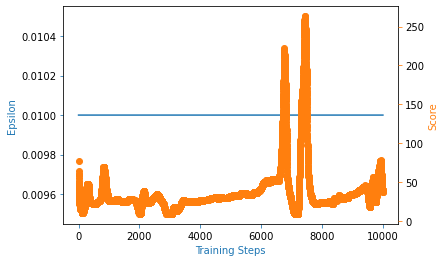

In [16]:
filename = 'cartpole_simple_dqn'
x = [i+1 for i in range(n_games)]
plot_learning_curve(x, scores, eps_history, filename)